In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from matplotlib.patches import RegularPolygon
from IPython.display import Markdown, display,Image,HTML
import math

Pick distinct positive integers A , B , and C , and place them in the grid above. Your goal is to create two corner-to-corner trips — one from a1 to f6 , and the other from

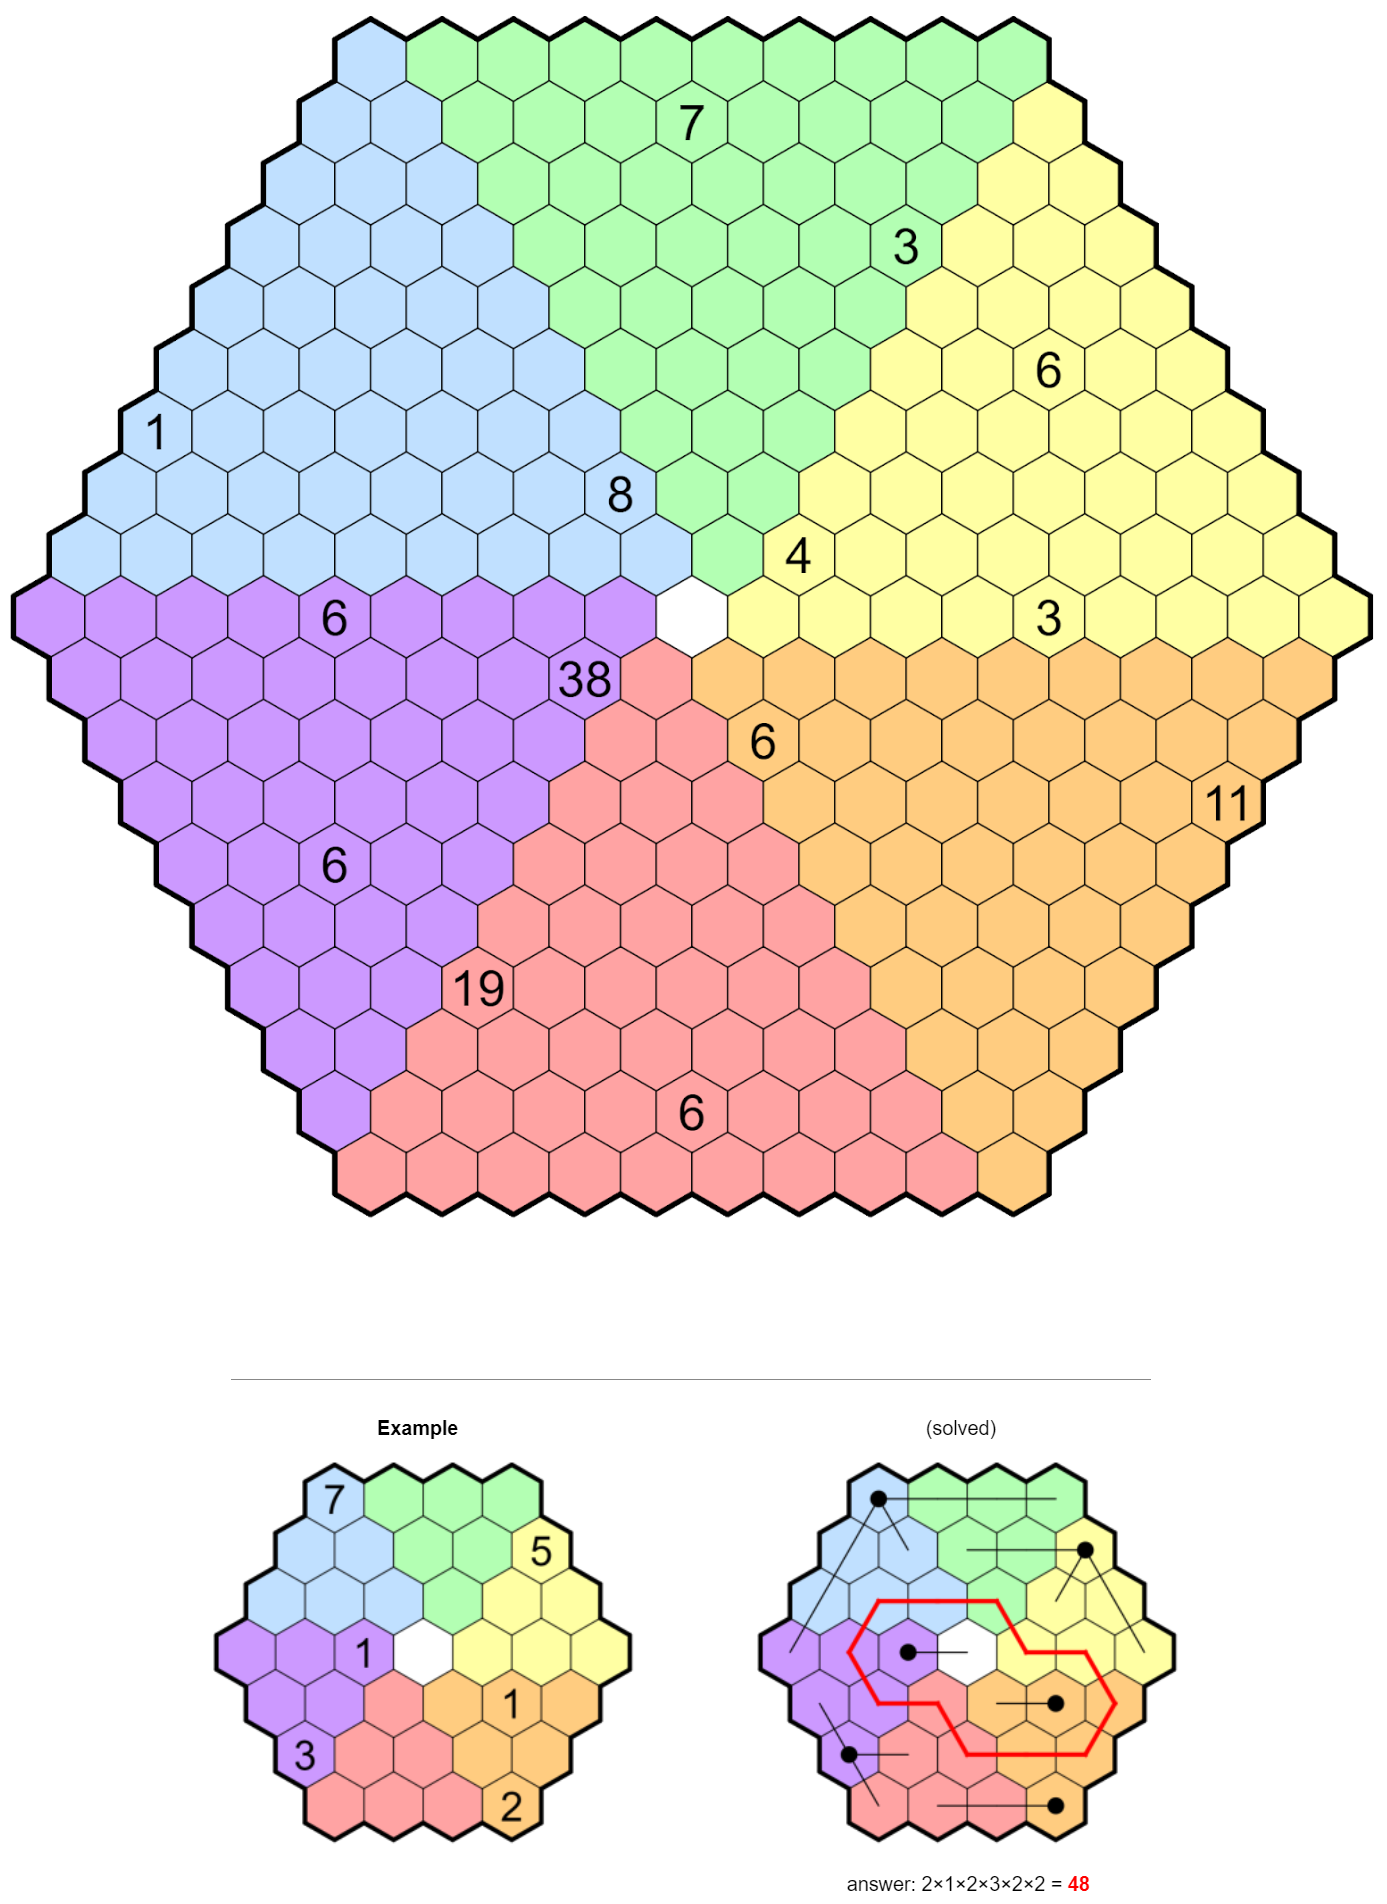

In [2]:
# This one actually easier using penpa https://tinyurl.com/287zppna

url='https://www.janestreet.com/puzzles/current-puzzle/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown(" ".join(x[14:26])))
display(Image('https://www.janestreet.com/puzzles/september-2024.png',width=400))

In [3]:
def segment(x,y,z):
    if x==0 and y==0 and z==0:     return 0;
    elif x > 0 and z >= 0 :        return 1;
    elif y < 0 and x <= 0:         return 2;
    elif x > 0 and y <= 0:         return 3;
    elif z > 0 and y >= 0:         return 4;
    elif x < 0 and  z<= 0:         return 5;
    elif y > 0 and x >= 0:         return 6;
    else:                          return 0;

In [4]:
def hex_grid(size,labels,fixed,ref=True):
    cols = ["w","cyan","purple","lightgreen","red","orange","yellow"]
    coord =[]
    if size == 3:
        txtsize =10
    else:
        txtsize =12
    
    for i,j,k in itertools.product(range(-size,size +1),repeat=3):
        if i+j+k ==0:
            coord += [(i,j,k)]
    
    fig, ax = plt.subplots(1,figsize=(size,size))
    
    for i,j,k in coord:
        y = i
        x = 2. * np.sin(np.radians(60)) * (j- k) /3.
        hex = RegularPolygon((x, y), numVertices=6, radius=2. / 3.,orientation=np.radians(60),facecolor =cols[segment(i,j,k)], fill = True,alpha = 0.4,linewidth =1,edgecolor='k')        
        ax.add_patch(hex)
        if ref:
            ax.text(x, y,str(i)+str(j)+str(k) , ha='center', va='center', size=txtsize-4)

    if ref == False:
        for (i,j,k),n in labels.items():
            if n!=0:
                y = i
                x = 2. * np.sin(np.radians(60)) * (j- k) /3.
                if n == -99:
                    hex2 = RegularPolygon((x, y), numVertices=6, radius=2. / 3.,orientation=np.radians(60),color ="k", fill = True,linewidth =1)    
                    ax.add_patch(hex2)
                else:
                    ax.text(x, y, n , ha='center', va='center', size=txtsize)             
    ax.set_aspect('equal')
    
    hcoord = [c[0] for c in coord]
    vcoord = [2. * np.sin(np.radians(30)) * (c[1] - c[2]) /3. for c in coord]
    ax.scatter(hcoord, vcoord,color ="w",alpha = 0)
    plt.axis("off")
    plt.show()

In [5]:
def scorer(labels):
    score = [0,0,0,0,0,0]
    for (i,j,k),n in labels.items():
        if n == -99:
            if segment(i,j,k) > 0:
                score[segment(i,j,k)-1] +=1
    return score,np.prod(score)

In [6]:
def get_line(labels,i,j,k,direction,way):
    output = []
    point = [i,j,k]
    if direction == 0:
        point[1] += way
        point[2] -= way
    if direction == 1:
        point[0] += way
        point[2] -=way
    if direction == 2:
        point[0] +=way
        point[1] -=way          
    while tuple(point) in labels:
        output += [labels[tuple(point)]]
        if direction == 0:
            point[1] +=way
            point[2] -=way
        if direction == 1:
            point[0] +=way
            point[2] -=way
        if direction == 2:
            point[0] +=way
            point[1] -=way
    return output

In [7]:
def get_clear(labels,label_value,i,j,k,direction,way,steps):
    output = {}
    if steps>0:
        steps_taken = 1
        point = [i,j,k]
        if direction == 0:
            point[1] += way
            point[2] -= way
        if direction == 1:
            point[0] += way
            point[2] -=way
        if direction == 2:
            point[0] +=way
            point[1] -=way
            
        while steps_taken <= steps:
            output[tuple(point)] = -label_value
            if direction == 0:
                point[1] +=way
                point[2] -=way
            if direction == 1:
                point[0] +=way
                point[2] -=way
            if direction == 2:
                point[0] +=way
                point[1] -=way
            steps_taken +=1
    #print(output)
    return output


In [8]:
def clearance(labels,i,j,k):
        num = labels[i,j,k]
      
        x_min = get_line(labels,i,j,k,0,-1)
        x_max = get_line(labels,i,j,k,0,1)
        y_min = get_line(labels,i,j,k,1,-1)
        y_max = get_line(labels,i,j,k,1,1)
        z_min = get_line(labels,i,j,k,2,-1)
        z_max = get_line(labels,i,j,k,2,1)
        
        bounds = [x_min,x_max,y_min,y_max,z_min,z_max]
        #print(bounds)
        allowed = [0,-num]
        clearance = []
        
        for i in range(6):
            for n in range(len(bounds[i])):
                if bounds[i][n] not in allowed:
                    n -=1
                    break                        
            if len(bounds[i])==0:
                n=-1
            clearance.append(n+1)
        return clearance

#print(clearance(labels,3,-3,0))
#clearance(labels,-3,3,0)

In [9]:
def forced_by_clearance(fixed,labels,i,j,k,n):
        forced ={}
        label_value = labels[i,j,k]
        space  = clearance(labels,i,j,k)
        tot_space= sum(clearance(labels,i,j,k))-n
        if tot_space < 0:
            print("label no",label_value,n,space,"not possible")
        elif tot_space ==0:
            print("Forced",label_value,n,space)
            forced.update(get_clear(labels,label_value,i,j,k,0,-1,space[0]))
            forced.update(get_clear(labels,label_value,i,j,k,0,1,space[1]))
            forced.update(get_clear(labels,label_value,i,j,k,1,-1,space[2]))
            forced.update(get_clear(labels,label_value,i,j,k,1,1,space[3]))
            forced.update(get_clear(labels,label_value,i,j,k,2,-1,space[4]))
            forced.update(get_clear(labels,label_value,i,j,k,2,1,space[5]))
        return forced

In [10]:
size =9
fixed = {(8, -4, -4): 7, (6, 0, -6): 3, (4, 3, -7): 6, (3, -9, 6): 1, (2, -2, 0): 8, (1, 1, -2): 4, (0, -5, 5): 6, (0, 5, -5): 3, (-1, -1, 2): 38, (-2, 2, 0): 6, (-3, 9, -6): 11,
         (-4, -3, 7): 6, (-6, 0, 6): 19, (-8, 4, 4): 6}

labels = {}
label_value = 1

#set up the grid
for i,j,k in itertools.product(range(-size,size +1),repeat=3):
        if i+j+k ==0:
            labels[i,j,k] = 0

for (i,j,k),n in fixed.items():
    labels[i,j,k]=label_value
    label_value +=1

#force values
loop = [ (9, -9, 0), (9, -8, -1), (9, -7, -2), (9, -6, -3), (9, -5, -4), (9, -4, -5), (9, -3, -6), (9, -2, -7),(9, -1, -8), (8, 0, -8), (7, 1, -8), (6, 2, -8), (5, 3, -8), (4, 4, -8), (3, 5, -8), 
        (2, 6, -8), (1, 7, -8), (0, 7, -7), (-1, 7, -6),(-2, 7, -5), (-3, 7, -4), (-3, 6, -3),(-4,6,-2),(-5,6,-1),(-6,7,-1),(-7,7,0),(-7,6,1),(-6,5,1),(-5, 5, 0), (-4, 5, -1), (-3, 5, -2), (-2, 5, -3),
        (-1, 6, -5), (-2, 6, -4), (-3, 6, -3),(0, 6, -6), (1, 5, -6), (2, 4, -6),(2,3,-5),(1,3,-4),(1,2,-3),(1, 2, -3), (2, 1, -3), (3, 1, -4), (4, 1, -5), (5, 1, -6),(8, -1, -7), (7, 0, -7), (6, 1, -7),
       (8, -9, 1), (7, -9, 2), (6, -9, 3), (5, -9, 4),(7, -8, 1), (6, -8, 2), (5, -8, 3), (4, -8, 4), (3, -8, 5), (2, -8, 6),
        (4, -7, 3), (3, -7, 4), (2, -7, 5), (1, -7, 6), (0, -7, 7),(0,-7,7),(0,-8,8),(1,-9,8),(2,-9,7),
       (7,-7,0),(7,-6,-1),(6,-5,-1),(5,-5,0),(4,-4,0),(4,-3,-1),(5, -3, -2), (6, -3, -3), (7, -3, -4), (8, -3, -5),(8,-2,-6)]

for x,y,z in loop:
    labels[x,y,z] = -99
    
# set the 38 lines to constrain the 19
labels[-1,-5,6] = -9
labels[-2,-0,2] = -9
labels[-6,4,2] = -9


Forced 1 7 [4, 0, 3, 0, 0, 0]
Forced 3 6 [1, 0, 1, 0, 3, 1]
Forced 4 1 [0, 0, 0, 1, 0, 0]
Forced 11 11 [1, 0, 6, 3, 0, 1]
Forced 13 19 [3, 3, 3, 3, 3, 4]
Forced 9 38 [7, 6, 3, 8, 8, 6]
Forced 10 6 [1, 2, 1, 0, 2, 0]
Forced 12 6 [2, 0, 1, 0, 1, 2]
Forced 14 6 [1, 1, 1, 1, 1, 1]
Forced 5 8 [1, 0, 1, 5, 0, 1]
Forced 6 4 [1, 0, 1, 0, 1, 1]
Forced 7 6 [1, 2, 0, 2, 0, 1]
Forced 8 3 [2, 0, 0, 0, 0, 1]
Forced 2 3 [0, 0, 3, 0, 0, 0]


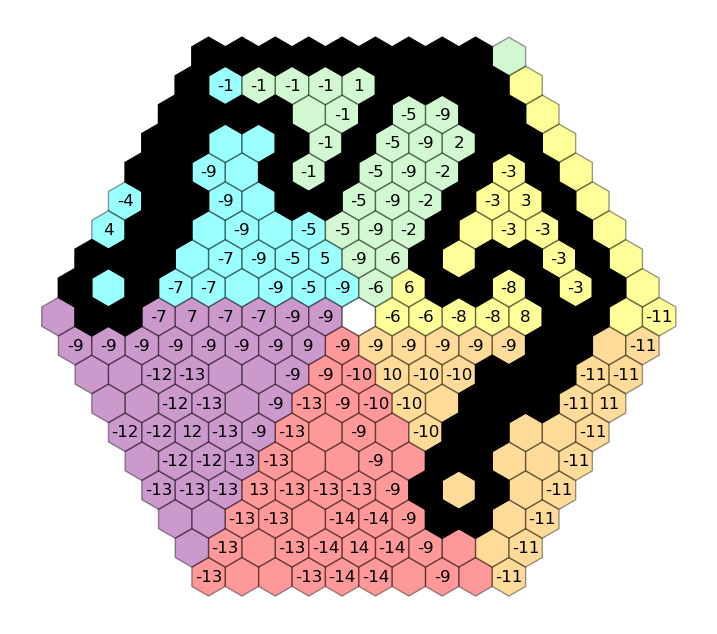

([20, 2, 19, 2, 14, 19], 404320)

In [11]:
done = []

changed = True
while changed:
    changed = False
    for (i,j,k),n in fixed.items():
        if labels[i,j,k] not in done:
            updates = forced_by_clearance(fixed,labels,i,j,k,n)
            if len(updates)>0 :
                done += [labels[i,j,k]]
                #print(updates)
                changed = True
                for (i,j,k),n in updates.items():
                    labels[i,j,k] = n
      
hex_grid(size,labels,fixed,ref= False)

scorer(labels)

The configuration of posts that permits a symmetric loop, passing through all six colored regions and making only 120-degree turns, is shown above. The product of the number of cells visited by the loop in each of the six regions is 404,320 .

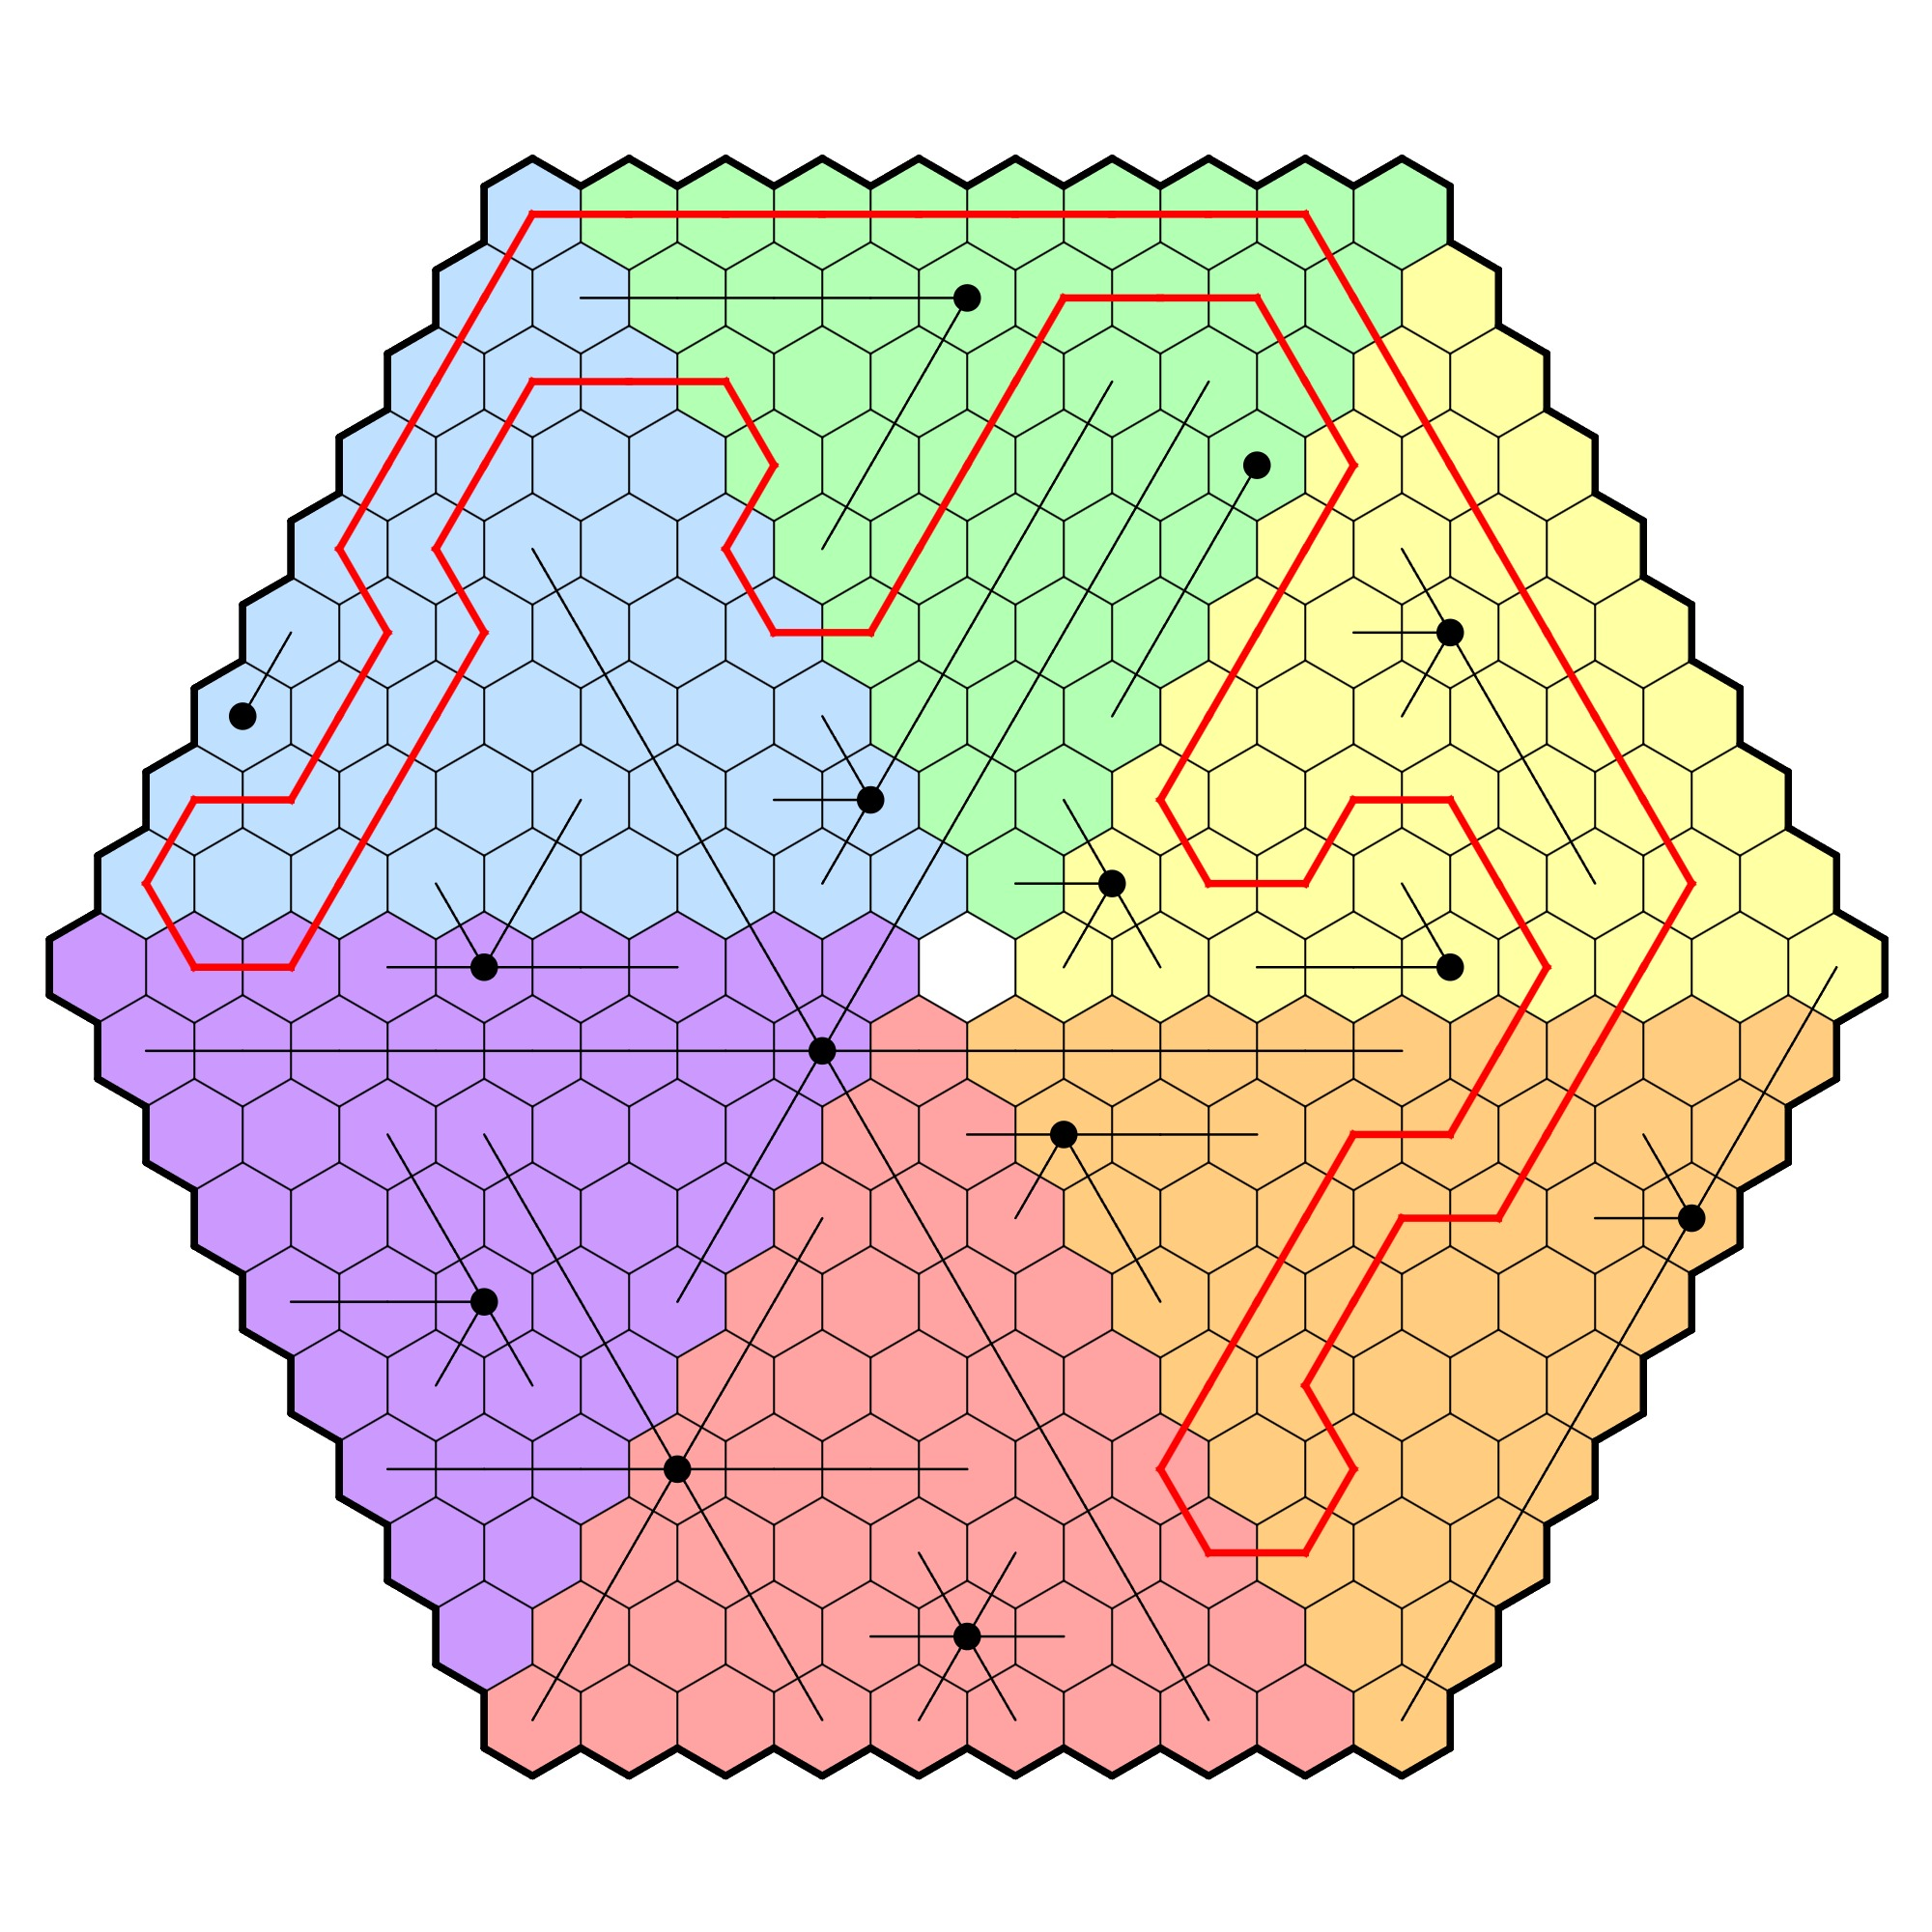

In [32]:
url='https://www.janestreet.com/puzzles/fences-2-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown(" ".join(x[16:19])))
display(Image('https://www.janestreet.com/puzzles/september-2024-ans.png',width=400))

Forced 2 5 [0, 0, 2, 0, 1, 2]
Forced 3 4 [0, 0, 2, 1, 0, 1]
Forced 4 2 [0, 0, 0, 1, 0, 1]
Forced 5 2 [0, 0, 0, 2, 0, 0]
Forced 1 4 [0, 2, 2, 0, 0, 0]


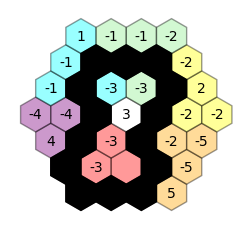

([2, 3, 2, 3, 2, 2], 144)

In [14]:
# parameters
size =3
fixed = {(3,-3,0):4,(1,2,-3):5,(0,0,0):4,(-1,-2,3):2,(-3,3,0):2}      
labels = {}
label_value = 1

#set up the grid
for i,j,k in itertools.product(range(-size,size +1),repeat=3):
        if i+j+k ==0:
            labels[i,j,k] = 0

for (i,j,k),n in fixed.items():
    labels[i,j,k]=label_value
    label_value +=1

#force values
labels[-3,0,3] = -99
labels[-3,1,2] = -99
labels[-3,2,1] = -99
labels[-2,2,0] = -99
labels[-1,1,0] = -99
labels[0,1,-1] = -99
labels[1,1,-2] = -99
labels[2,0,-2] = -99
labels[2,-1,-1] = -99
labels[2,-2,0] = -99
labels[1,-2,1] = -99
labels[0,-1,1] = -99
labels[-1,-1,2] = -99
labels[-1,-1,2] = -99
labels[-2,-1,3] = -99

#determine the forced cells

done = []
changed = True
while changed:
    changed = False
    for (i,j,k),n in fixed.items():
        if labels[i,j,k] not in done:
            updates = forced_by_clearance(fixed,labels,i,j,k,n)
            if len(updates)>0 :
                done += [labels[i,j,k]]
                #print(updates)
                changed = True
                for (i,j,k),n in updates.items():
                    labels[i,j,k] = n

                
hex_grid(size,labels,fixed,ref= False)

scorer(labels)